# Import Libraries

In [77]:
import random
import torch
import torch.nn as nn
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
file_name = 'diabetes_scale'

# Data to load

In [78]:
# Load data
X, y = load_svmlight_file(file_name)
X_dense = X.toarray()
# Split dataset (6:2:2)
X_train_all, X_test, y_train_all, y_test = train_test_split(X_dense, y, test_size=0.2, random_state=42)

X_train_all = torch.FloatTensor(X_train_all).to(device)
y_train_all = torch.FloatTensor(y_train_all).unsqueeze(1).to(device)
y_train_all = (y_train_all + 1) / 2

X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).unsqueeze(1).to(device)
y_test = (y_test + 1) / 2

# hyper-parameters and model difination

In [79]:
lr = 0.001
batch_size = 128
epochs = 100

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size2, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x)
        return x

# Train and Test

In [80]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


model = MLP(X_train_all.shape[1], 32, 4, 1).to(device)
model.train()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
custom_dataset = CustomDataset(X_train_all, y_train_all)
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
criterion = nn.BCELoss()

loss_epoch = 0

for epoch in range(epochs):
    for batch_X, batch_y in data_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item() * batch_X.shape[0]
    loss_epoch /= X_train_all.shape[0]
    # print(loss_epoch)

with torch.no_grad():
    model.eval()
    test_outputs = model(X_test)
    test_predicted = (test_outputs > 0.5).float()
    test_accuracy = accuracy_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    test_precision = precision_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    test_recall = recall_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
    test_f1 = f1_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())

    print('Test Accuracy:', test_accuracy)
    print('Test Precision:', test_precision)
    print('Test Recall:', test_recall)
    print('Test F1 Score:', test_f1)

Test Accuracy: 0.7662337662337663
Test Precision: 0.8118811881188119
Test Recall: 0.8282828282828283
Test F1 Score: 0.8200000000000001


# Other Methods

In [81]:
X_train_all = X_train_all.detach().cpu().numpy()
y_train_all = y_train_all.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()
y_test = y_test.detach().cpu().numpy()

# Linear Regression
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_all, y_train_all)

# Predict
logistic_reg_predictions = logistic_reg.predict(X_test)
logistic_reg_predictions = (logistic_reg_predictions > 0.5).astype(int)

# Evaluate
logistic_reg_accuracy = accuracy_score(y_test, logistic_reg_predictions)
logistic_reg_precision = precision_score(y_test, logistic_reg_predictions)
logistic_reg_recall = recall_score(y_test, logistic_reg_predictions)
logistic_reg_f1 = f1_score(y_test, logistic_reg_predictions)

print('Logistic Regression Accuracy:', logistic_reg_accuracy)
print('Logistic Regression Precision:', logistic_reg_precision)
print('Logistic Regression Recall:', logistic_reg_recall)
print('Logistic Regression F1 Score:', logistic_reg_f1)

# Linear Kernel SVM
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train_all, y_train_all)

# Predict
linear_svm_predictions = linear_svm.predict(X_test)

# Evaluate
linear_svm_accuracy = accuracy_score(y_test, linear_svm_predictions)
linear_svm_precision = precision_score(y_test, linear_svm_predictions)
linear_svm_recall = recall_score(y_test, linear_svm_predictions)
linear_svm_f1 = f1_score(y_test, linear_svm_predictions)

print('Linear Kernel SVM Accuracy:', linear_svm_accuracy)
print('Linear Kernel SVM Precision:', linear_svm_precision)
print('Linear Kernel SVM Recall:', linear_svm_recall)
print('Linear Kernel SVM F1 Score:', linear_svm_f1)

# KNN
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train_all, y_train_all)
knn_predictions = knn.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_precision = precision_score(y_test, knn_predictions)
knn_recall = recall_score(y_test, knn_predictions)
knn_f1 = f1_score(y_test, knn_predictions)

print('KNN Accuracy:', knn_accuracy)
print('KNN Precision:', knn_precision)
print('KNN Recall:', knn_recall)
print('KNN F1 Score:', knn_f1)

import matplotlib.pyplot as plt

Logistic Regression Accuracy: 0.7532467532467533
Logistic Regression Precision: 0.8080808080808081
Logistic Regression Recall: 0.8080808080808081
Logistic Regression F1 Score: 0.8080808080808081
Linear Kernel SVM Accuracy: 0.7597402597402597
Linear Kernel SVM Precision: 0.81
Linear Kernel SVM Recall: 0.8181818181818182
Linear Kernel SVM F1 Score: 0.8140703517587939
KNN Accuracy: 0.6883116883116883
KNN Precision: 0.7428571428571429
KNN Recall: 0.7878787878787878
KNN F1 Score: 0.7647058823529412


# Plotting

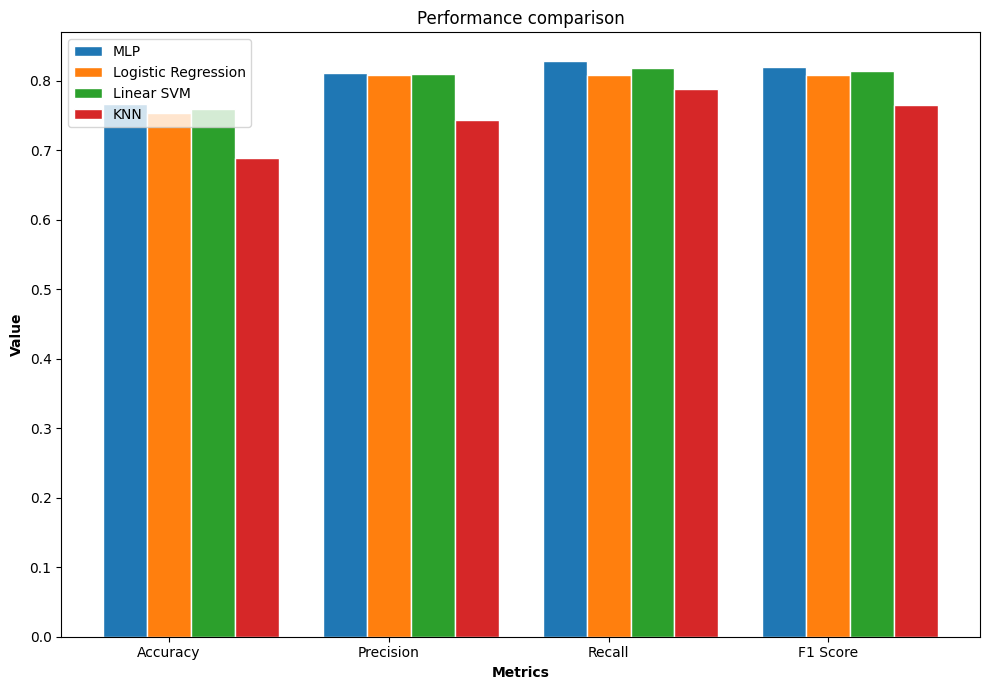

In [82]:
# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Model performance data collected from previous code
mlp_performance = [test_accuracy, test_precision, test_recall, test_f1]
logreg_performance = [logistic_reg_accuracy, logistic_reg_precision, logistic_reg_recall, logistic_reg_f1]
svm_performance = [linear_svm_accuracy, linear_svm_precision, linear_svm_recall, linear_svm_f1]
knn_performance = [knn_accuracy, knn_precision, knn_recall, knn_f1]

barWidth = 0.2
r1 = np.arange(len(mlp_performance))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 7))

# Create bar chart
plt.bar(r1, mlp_performance, width=barWidth, edgecolor='white', label='MLP')
plt.bar(r2, logreg_performance, width=barWidth, edgecolor='white', label='Logistic Regression')
plt.bar(r3, svm_performance, width=barWidth, edgecolor='white', label='Linear SVM')
plt.bar(r4, knn_performance, width=barWidth, edgecolor='white', label='KNN')

# Add title and legend
plt.title('Performance comparison')
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(mlp_performance))], metrics)

plt.legend()
plt.tight_layout()
plt.show()